In [17]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [18]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Prueba Completa

In [19]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(count=3,
                         label="3y",
                         step="year",
                         stepmode="backward"),
                    dict(count=5,
                         label="5y",
                         step="year",
                         stepmode="backward"),
                    dict(count=10,
                         label="10y",
                         step="year",
                         stepmode="backward"),
                    dict(count=20,
                         label="20y",
                         step="year",
                         stepmode="backward"),
                    dict(count=30,
                         label="30y",
                         step="year",
                         stepmode="backward"),
                    dict(count=50,
                         label="50y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Indice de producción"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()


Rolling Forecast: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


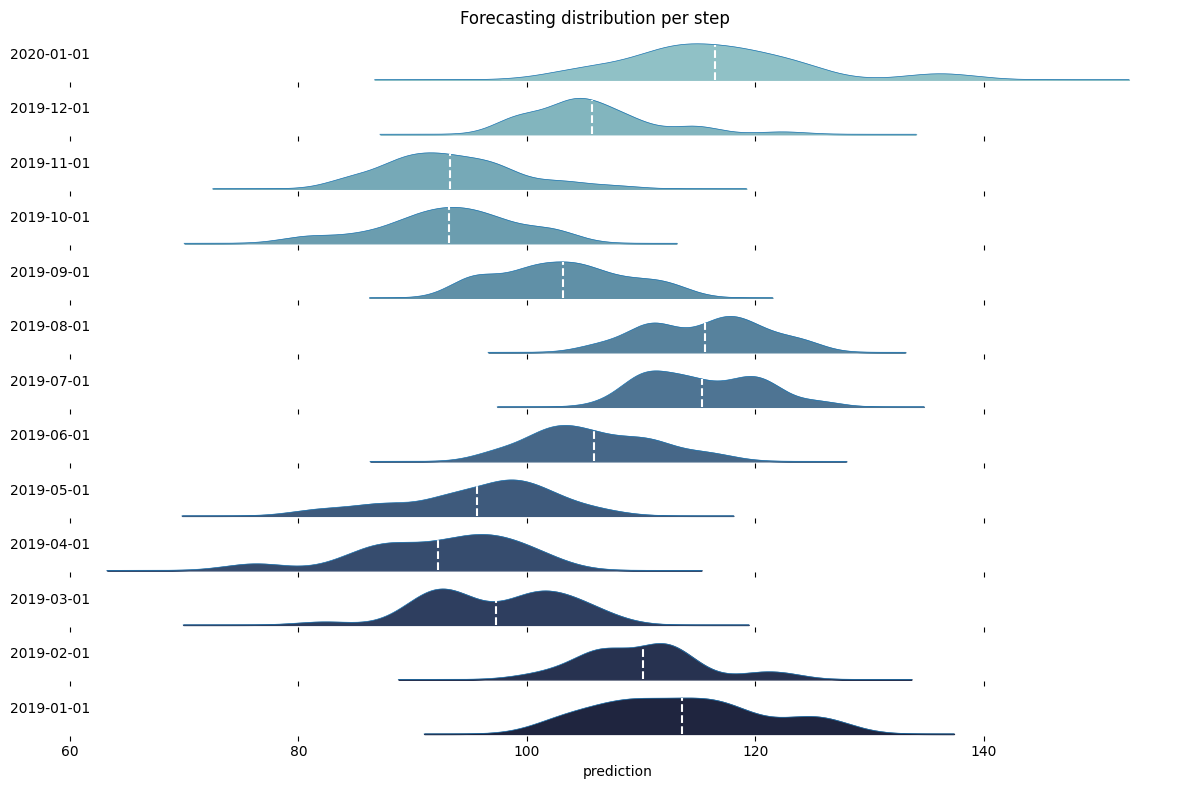

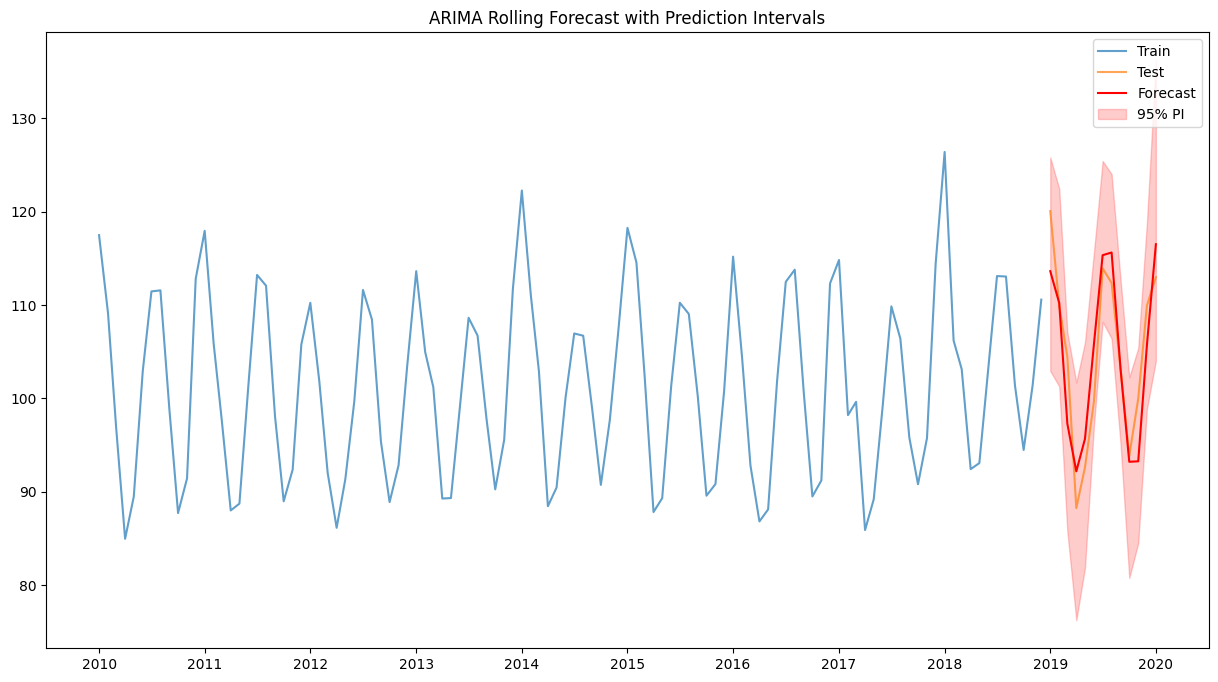

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Optional, Any
from tqdm import tqdm

warnings.filterwarnings('ignore')

def fit_arima_model(train_data):
    model = ARIMA(train_data, order=(2, 0, 2),freq='MS')  # You can adjust the order as needed
    return model.fit()

def predict_bootstrapping(model, train_data, steps=1, n_boot=500, random_state=123):
    predictions = model.forecast(steps=steps)
    residuals = model.resid
    
    boot_predictions = np.full((steps, n_boot), np.nan)
    rng = np.random.default_rng(seed=random_state)
    
    for i in range(n_boot):
        sample_residuals = rng.choice(residuals, size=steps, replace=True)
        boot_predictions[:, i] = predictions + sample_residuals
    
    return pd.DataFrame(boot_predictions, columns=[f"pred_boot_{i}" for i in range(n_boot)],
                        index=pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=steps, freq='MS'))

def rolling_forecast_with_bootstrapping(train, test, window_size=24, n_boot=500):
    all_bootstrap_predictions = []
    
    for i in tqdm(range(len(test)), desc="Rolling Forecast"):
        train_window = pd.concat([train, test.iloc[:i]])
        model = fit_arima_model(train_window.iloc[-window_size:])
        bootstrap_predictions = predict_bootstrapping(model, train_window.iloc[-window_size:], steps=1, n_boot=n_boot)
        all_bootstrap_predictions.append(bootstrap_predictions)
    
    return pd.concat(all_bootstrap_predictions)

def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')

    fig.subplots_adjust(hspace=-0)
    fig.suptitle('Forecasting distribution per step')
    return fig

def plot_forecast_with_pi(train, test, forecasts, lower_pi, upper_pi):
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train, label='Train', alpha=0.7)
    plt.plot(test.index, test, label='Test', alpha=0.7)
    plt.plot(forecasts.index, forecasts, label='Forecast', color='red')
    plt.fill_between(forecasts.index, lower_pi, upper_pi, color='red', alpha=0.2, label='95% PI')
    plt.title('ARIMA Rolling Forecast with Prediction Intervals')
    plt.legend()
    plt.show()

# Load and prepare the data
data = pd.read_csv('../../../data/IPG2211A2N_1.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['IPG2211A2N'] = pd.to_numeric(data['IPG2211A2N'], errors='coerce')
data.dropna(inplace=True)

train = data[data.index.year < 2019]
test = data[data.index.year >= 2019]

plot_('IPG2211A2N', (train.index, train['IPG2211A2N'], 'Train'), (test.index, test['IPG2211A2N'], 'Test'))

# Perform rolling forecast with bootstrapping
bootstrap_predictions = rolling_forecast_with_bootstrapping(train['IPG2211A2N'], test['IPG2211A2N'], window_size=24, n_boot=100)

# Plot the prediction distributions
fig = plot_prediction_distribution(bootstrap_predictions, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Calculate forecasts and prediction intervals
forecasts = bootstrap_predictions.mean(axis=1)
lower_pi = bootstrap_predictions.quantile(0.025, axis=1)
upper_pi = bootstrap_predictions.quantile(0.975, axis=1)

# Plot the forecast with prediction intervals
plot_forecast_with_pi(train['IPG2211A2N'], test['IPG2211A2N'], forecasts, lower_pi, upper_pi)

In [25]:
bootstrap_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_90,pred_boot_91,pred_boot_92,pred_boot_93,pred_boot_94,pred_boot_95,pred_boot_96,pred_boot_97,pred_boot_98,pred_boot_99
2019-01-01,125.649400,111.475889,118.496485,104.085531,114.977111,107.480574,113.421392,103.324487,108.618393,103.324487,...,111.475889,111.197176,113.011322,125.649400,109.717660,125.649400,108.618393,122.500543,111.475889,122.500543
2019-02-01,105.753092,106.847620,112.770249,108.959708,115.318066,111.530556,107.324090,105.778761,106.644362,105.778761,...,106.847620,103.918619,120.082762,105.753092,109.243810,105.753092,106.644362,122.441152,106.847620,122.441152
2019-03-01,94.443137,95.509814,95.861112,82.291396,99.500124,91.239602,92.710651,92.902180,99.067140,92.902180,...,95.509814,97.437032,107.042489,94.443137,101.339904,94.443137,99.067140,89.638836,95.509814,89.638836
2019-04-01,76.253134,97.286312,87.881050,87.451839,99.444732,88.211775,93.022011,86.127524,101.086885,86.127524,...,97.286312,94.670571,84.138629,76.253134,96.089211,76.253134,101.086885,100.056552,97.286312,100.056552
2019-05-01,81.878191,98.086106,93.439869,97.918747,95.118095,93.156706,97.343117,86.687912,106.013460,86.687912,...,98.086106,105.166325,101.534096,81.878191,98.400371,81.878191,106.013460,99.314221,98.086106,99.314221
2019-06-01,101.707297,107.809215,107.581229,114.244526,111.073316,105.360964,115.641596,99.810427,97.579556,99.810427,...,107.809215,117.541391,108.132717,101.707297,111.554798,101.707297,97.579556,104.204187,107.809215,104.204187
2019-07-01,120.076666,120.291373,113.433707,113.868833,109.988973,121.304188,125.411881,110.156591,119.199296,110.156591,...,120.291373,106.740332,111.344225,120.076666,118.220099,120.076666,119.199296,110.195906,120.291373,110.195906
2019-08-01,117.341050,118.649231,116.282472,105.737185,114.851584,124.003545,107.140161,120.385659,117.603086,120.385659,...,118.649231,121.909184,109.994075,117.341050,119.018348,117.341050,117.603086,112.424007,118.649231,112.424007
2019-09-01,96.069571,108.361253,109.990625,95.035350,99.312777,95.211536,111.416552,112.676840,101.379085,112.676840,...,108.361253,107.316521,101.626650,96.069571,100.318744,96.069571,101.379085,105.403128,108.361253,105.403128
2019-10-01,80.783287,90.047299,97.229323,92.041553,93.872716,102.184998,96.966282,85.271926,88.506461,85.271926,...,90.047299,90.657278,95.182035,80.783287,97.344915,80.783287,88.506461,93.990637,90.047299,93.990637


In [26]:
bootstrap_predictions.to_csv('bootstrap_predictions_ARIMA_1_0_13.csv')

In [27]:
import scoringrules as sr
import numpy as np

# Calculate CRPS for the bootstrap predictions
def calculate_crps(observations, forecast_ensemble):
    crps_values = []
    for i in range(len(observations)):
        obs = np.array([observations[i]])
        fct = forecast_ensemble.iloc[i].values
        crps = sr.crps_ensemble(obs, fct)
        crps_values.append(crps)
    return np.mean(crps_values)

# Extract the observed values and the forecast ensemble
observed_values = test['IPG2211A2N'].values
forecast_ensemble = bootstrap_predictions.T

# Calculate and print the CRPS
crps_score = calculate_crps(observed_values, forecast_ensemble)
print(f"CRPS Score: {crps_score}")


CRPS Score: 4.681002496127946
